In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model
from tensorflow.keras import backend as k
import numpy as np
import json
import os
import gc
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [2]:
class MMHSALayer(Layer):
    def __init__(self,heads=8):
        super(MMHSALayer, self).__init__()
        self.heads = heads

    def build(self,input_shape):
        self.model_dim = input_shape[-2]
        self.k = self.add_weight(shape=(self.heads,self.model_dim,self.model_dim),
                                 initializer='random_normal',
                                 trainable=True,
                                 name="Key")
        self.q = self.add_weight(shape=(self.heads,self.model_dim,self.model_dim),
                                 initializer='random_normal',
                                 trainable=True,
                                 name="Query")
        self.v = self.add_weight(shape=(self.heads,self.model_dim,self.model_dim),
                                 initializer='random_normal',
                                 trainable=True,
                                 name="Value")
        self.o = self.add_weight(shape=(self.model_dim,self.model_dim*self.heads),
                                 initializer='random_normal',
                                 trainable=True,
                                 name="Heads")

    def call(self,inputs):
        mask_shape = inputs.shape[-1]

        mask_0 = np.ones((mask_shape,mask_shape))
        for i in range(mask_shape):
            for j in range(mask_shape):
                if (i>j):
                    mask_0[i][j]=0
        self.mask_0 = tf.constant(mask_0,dtype=tf.float32)

        mask_inf = np.zeros((mask_shape,mask_shape))
        for i in range(mask_shape):
            for j in range(mask_shape):
                if (i>j):
                    mask_inf[i][j]=-10000000000
        self.mask_inf = tf.constant(mask_inf,dtype=tf.float32)

        inputs = tf.expand_dims(inputs,1)

        key=tf.matmul(self.k,inputs)
        que=tf.matmul(self.q,inputs)
        val=tf.matmul(self.v,inputs)

        Z=tf.matmul(tf.transpose(key,perm=[0,1,3,2]),que)*(1/np.sqrt(self.model_dim))
        W=tf.multiply(Z,self.mask_0)
        W=tf.add(W,self.mask_inf)
        W=tf.keras.activations.softmax(W,axis=1)
        W=tf.multiply(W,self.mask_0)
        W=tf.matmul(val,W)

        W = tf.reshape(W,(inputs.shape[0],self.model_dim*self.heads,mask_shape))

        ans = W

        ans = tf.matmul(self.o,ans)
        ans=tf.expand_dims(ans,0)

        ans = tf.squeeze(ans,axis=0)

        return ans

class Dense2D(Layer):
    def __init__(self,units):
        super(Dense2D, self).__init__()
        self.units = units

    def build(self,input_shape):
        input_len = input_shape[-2]

        self.w = self.add_weight(shape=(self.units,input_len),
                                 initializer='random_normal',
                                 trainable=True,
                                 name="dense2dw")

    def call(self,inputs):

        ans = tf.matmul(self.w,inputs)

        return ans

class FFLayer(Layer):
    def __init__(self, dff=2048, dropout=0.1):
        super(FFLayer,self).__init__()
        self.dff = dff
        self.dropout = dropout

    def build(self,input_shape):
        self.dropout = tf.keras.layers.Dropout(self.dropout)
        self.dout = input_shape[-2]

        self.w1 = self.add_weight(shape=(self.dff,self.dout),
                                 initializer='random_normal',
                                 trainable=True,
                                 name="ffw1")
        self.w2 = self.add_weight(shape=(self.dout,self.dff),
                                 initializer='random_normal',
                                 trainable=True,
                                 name="ffw2")
        self.b1 = self.add_weight(shape=(self.dff,1),
                                 initializer='random_normal',
                                 trainable=True,
                                 name="ffb1")
        self.b2 = self.add_weight(shape=(self.dout,1),
                                 initializer='random_normal',
                                 trainable=True,
                                 name="ffb2")

    def call(self,inputs):

        ans = tf.add(tf.matmul(self.w1,inputs),self.b1)
        ans = tf.keras.activations.relu(ans)
        ans = tf.add(tf.matmul(self.w2,ans),self.b2)

        ans = self.dropout(ans)

        return ans

class ANLayer(Layer):
    def __init__(self):
        super(ANLayer,self).__init__()
        self.Normal = tf.keras.layers.LayerNormalization(axis=1)

    def call(self,inputs1,inputs2):
        sum = tf.add(inputs1,inputs2)
        ans=self.Normal(sum)
        return ans

In [3]:
class LTModel(Model):
    def __init__(self, input_shape, layers, heads, dff, model_dim, dropout):
        super(LTModel, self).__init__()

        self.emb = Dense2D(model_dim)

        self.SA = []
        self.AN1 = []
        self.FF = []
        self.AN2 = []

        for i in range(layers):
            self.SA.append(MMHSALayer(heads))
            self.AN1.append(ANLayer())
            self.FF.append(FFLayer(dff, dropout))
            self.AN2.append(ANLayer())

        self.deemb = Dense2D(input_shape)
        self.sm = tf.keras.layers.Softmax(axis=1)

    def call(self, x):
        x = self.emb(x)

        for i in range(len(self.SA)):
            y = self.SA[i](x)
            x = self.AN1[i](x,y)
            y = self.FF[i](x)
            x = self.AN2[i](x,y)

        x = self.deemb(x)
        x = self.sm(x)

        return x

In [4]:
class LayoutTransformer:

    def __init__(self, n_classes, class_labels,n_anchors=(32,32), d=512, n_layers=6, n_heads=8, dff=2048, dropout=0.1):
        self.n_classes = n_classes+2
        self.n_anchors = n_anchors
        self.d = d
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.dff = dff
        self.dropout = dropout
        self.n_row = n_anchors[0]
        self.n_col = n_anchors[1]
        self.input_dim = 2+n_classes+2*(n_anchors[0]+n_anchors[1])
        self.model = LTModel(self.input_dim, model_dim=d, layers=n_layers, heads=n_heads, dff=dff, dropout=dropout)
        self.loss_his = []

    def build(self):
        self.model.build((1,self.input_dim,1))

    def load_weights(self, folder_path, filename):
        self.build()
        self.model.load_weights(folder_path + '/' + str(filename) + '.h5')

    def summary(self):
        self.build()
        print(self.model.summary())

In [5]:
import numpy as np
x_data=np.load('C://Users//kishore prashanth//Downloads//x_data.npy',allow_pickle=True)
x_data.shape

(80788, 141, 10)

In [6]:
publay_model = LayoutTransformer(n_classes=11, class_labels=["None","Living room","Master room","Kitchen","Bathroom","Dining room",
              "Child room","Study room","Second room","Guest room","Balcony"])

In [7]:
publay_model.load_weights("C://Users//kishore prashanth//Desktop//Second Review//","modelT20")

In [8]:
publay_model.summary()

Model: "lt_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense2d (Dense2D)           multiple                  72192     
                                                                 
 mmhsa_layer (MMHSALayer)    multiple                  8388608   
                                                                 
 mmhsa_layer_1 (MMHSALayer)  multiple                  8388608   
                                                                 
 mmhsa_layer_2 (MMHSALayer)  multiple                  8388608   
                                                                 
 mmhsa_layer_3 (MMHSALayer)  multiple                  8388608   
                                                                 
 mmhsa_layer_4 (MMHSALayer)  multiple                  8388608   
                                                                 
 mmhsa_layer_5 (MMHSALayer)  multiple                  838

In [9]:
def onehot(box, prob=[-1,-1,-1,-1,-1]):
      p = 1.0
      c = np.argsort(box[0:publay_model.n_classes],axis=0)[prob[0]]
      x = np.argsort(box[publay_model.n_classes:publay_model.n_classes+publay_model.n_col],axis=0)[prob[1]] + publay_model.n_classes
      y = np.argsort(box[publay_model.n_classes+publay_model.n_col:publay_model.n_classes+publay_model.n_col+publay_model.n_row],axis=0)[prob[2]] + publay_model.n_classes+publay_model.n_col
      w = np.argsort(box[publay_model.n_classes+publay_model.n_col+publay_model.n_row:publay_model.n_classes+2*publay_model.n_col+publay_model.n_row],axis=0)[prob[3]] + publay_model.n_classes+publay_model.n_col+publay_model.n_row
      h = np.argsort(box[publay_model.n_classes+2*publay_model.n_col+publay_model.n_row:publay_model.n_classes+2*publay_model.n_col+2*publay_model.n_row],axis=0)[prob[4]] + publay_model.n_classes+2*publay_model.n_col+publay_model.n_row
      p = p*box[c][0]*box[x][0]*box[y][0]*box[w][0]*box[h][0]
      res = np.zeros((publay_model.input_dim,1))
      res[c,0]=1
      res[x,0]=1
      res[y,0]=1
      res[w,0]=1
      res[h,0]=1
      return (res,p)

In [10]:
def get_color(c):
      color_key = ["#00ffff","#fff5ee","#dc143c","#ffff00","#00ff00","#ff00ff","#1e90ff",
                    "#ff1493","#8b008b","#ff4500","#8b4513","#808000","#483d8b"]
      return color_key[int(c)]

In [11]:
def sort_prob(rooms):
        p = [int(p) for box,p in rooms]
        p = np.argsort(p)[::-1]
        res = []
        for i in p:
            res.append(rooms[i])
        return res

In [42]:
validRoomIds=np.load('C://Users//kishore prashanth//Downloads//ValidRoomIndices.npy')
roomID=0
for i in range(24,30):
    if roomID in validRoomIds:
        print(roomID," is present")
    else:
        print(roomID," is not present")
    roomID+=1

0  is not present
1  is not present
2  is present
3  is not present
4  is present
5  is not present


In [40]:
validRoomIds[23]

183

In [82]:
which_img=[22]
which_rooms=[0,1,2]

In [83]:
# which_img=[]
# roomID=0
# i=0
# while (i<1000):
#     if roomID in validRoomIds:
#         which_img.append(roomID)
#         i+=1
#     roomID+=1
# which_rooms=range(0,2)

In [84]:
X=x_data[which_img,:,:]
class_labels=["BOS","None","Living room","Master room","Kitchen","Bathroom","Dining room",
              "Child room","Study room","Second room","Guest room","Balcony","EOS"]
for input_count,input in enumerate(X):
  print(input_count)
  input=np.array([input])
  index=0
  for box in input.T:
      c = np.argmax(box[0:publay_model.n_classes],axis=0)
      print(str(index)+"th index - "+class_labels[int(c)])
      index+=1

0
0th index - BOS
1th index - Master room
2th index - Second room
3th index - Living room
4th index - Bathroom
5th index - Kitchen
6th index - None
7th index - None
8th index - None
9th index - None


C:\Users\kishore prashanth\AppData\Local\Temp\ipykernel_5192\4171087101.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(str(index)+"th index - "+class_labels[int(c)])


In [85]:
import matplotlib.patches as mpatches
labels = ["Living room","Master room","Kitchen","Bathroom","Dining room",
              "Child room","Study room","Second room","Guest room","Balcony"]
colors = [get_color(i) for i in range(2,12)]
legend_handles=[]
for i in range(len(labels)):
  legend_handles.append(mpatches.Patch(color=colors[i], label=labels[i]))

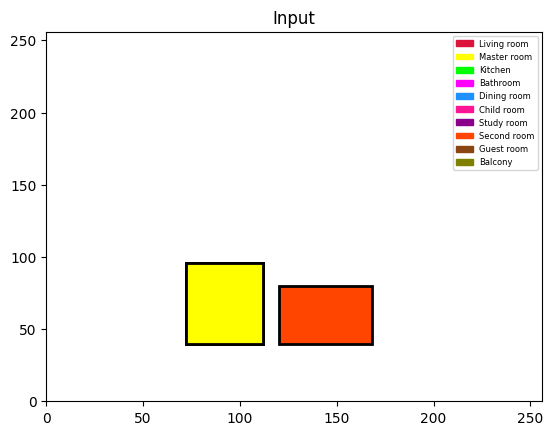

In [86]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#x_data[[0],:,:][:,:,[0,1,2]]
#x_data[which_img,:,:][:,:,which_rooms]
area=[]
temp=[]
for box in x_data[which_img,:,:][:,:,which_rooms].T:
    c = np.argmax(box[0:publay_model.n_classes],axis=0)
    x = np.argmax(box[publay_model.n_classes:publay_model.n_classes+publay_model.n_col],axis=0)
    y = np.argmax(box[publay_model.n_classes+publay_model.n_col:publay_model.n_classes+publay_model.n_col+publay_model.n_row],axis=0)
    w = np.argmax(box[publay_model.n_classes+publay_model.n_col+publay_model.n_row:publay_model.n_classes+2*publay_model.n_col+publay_model.n_row],axis=0)
    h = np.argmax(box[publay_model.n_classes+2*publay_model.n_col+publay_model.n_row:publay_model.n_classes+2*publay_model.n_col+2*publay_model.n_row],axis=0)
    x,y,w,h=(x/32.0)*256,(y/32.0)*256,(w/32.0)*256,(h/32.0)*256

    area.append(w[0]*h[0])
    temp.append((c[0],x[0],y[0],w[0],h[0]))
    if c==publay_model.n_classes-1:
        break
    arr=np.argsort(area)[::-1]
    for i in arr:
        c,x,y,w,h=temp[i][0],temp[i][1],temp[i][2],temp[i][3],temp[i][4]
        if c>=2 and c<=11:
            r = plt.Rectangle((x,y),w,h, fc=get_color(c), ec='#000000',linewidth=2) #ffffff #000000
            ax.add_patch(r)

ax.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1, 1),prop={'size': 6})
ax.set_xlim(0, 256)
ax.set_ylim(0, 256)
ax.set_title("Input")
#plt.axis('off')
plt.show()

In [87]:
temp

[(0, 0.0, 0.0, 0.0, 0.0),
 (3, 72.0, 40.0, 40.0, 56.0),
 (9, 120.0, 40.0, 48.0, 40.0)]

In [88]:
#Set which_img and which_rooms 
# which_img=range(0,1)
# which_rooms=range(0,3)

In [89]:
#Set which_img and which_rooms (only valid ones)
# which_img=[]
# roomID=0
# i=0
# while (i<50):
#     if roomID in validRoomIds:
#         which_img.append(roomID)
#         i+=1
#     roomID+=1
# which_rooms=range(0,2)

In [90]:
def fn(layouts_array=[0,1],rooms_array=[0,1],max_rooms=10):
  x=x_data[layouts_array,:,:][:,:,rooms_array]
  res = []

  for input_count,input in enumerate(x):
      input = np.array([input])
      most_prob_layout=[(input,1)]

      for step in range(max_rooms):
          cur = most_prob_layout.pop(0)
          pre = np.array([publay_model.model(cur[0]).numpy()[0,:,-1]])
          (box,p) = onehot(pre.T,[-1,-1,-1,-1,-1])
          p=p*cur[1]
          cur_box = np.array([box])
          cur_doc = np.append(cur[0],cur_box,axis=2)

          most_prob_layout.append((cur_doc,p))

          if most_prob_layout[0][0][0,publay_model.n_classes-1,-1]==1:
              break
      res.append([*most_prob_layout])
  return res
res=fn(layouts_array=which_img,rooms_array=which_rooms,max_rooms=10)
#res=fn(layouts_array=[0],rooms_array=[0,1,2],max_rooms=10)

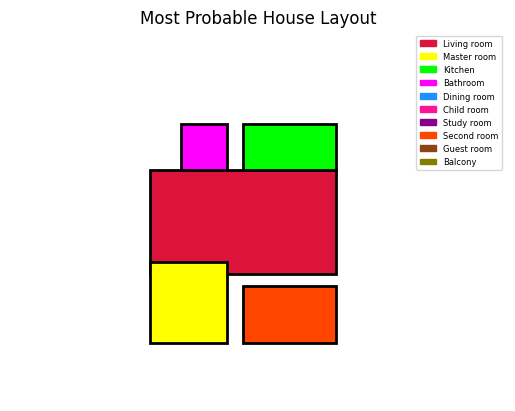

In [91]:
plt.style.use('default')
for i in range(len(res)):
  layout=res[i][0]
  fig, ax = plt.subplots()
  area=[]
  temp=[]
  for box in layout[0].T:
      c = np.argmax(box[0:publay_model.n_classes],axis=0)
      x = np.argmax(box[publay_model.n_classes:publay_model.n_classes+publay_model.n_col],axis=0)
      y = np.argmax(box[publay_model.n_classes+publay_model.n_col:publay_model.n_classes+publay_model.n_col+publay_model.n_row],axis=0)
      w = np.argmax(box[publay_model.n_classes+publay_model.n_col+publay_model.n_row:publay_model.n_classes+2*publay_model.n_col+publay_model.n_row],axis=0)
      h = np.argmax(box[publay_model.n_classes+2*publay_model.n_col+publay_model.n_row:publay_model.n_classes+2*publay_model.n_col+2*publay_model.n_row],axis=0)
      x,y,w,h=(x/32.0)*256,(y/32.0)*256,(w/32.0)*256,(h/32.0)*256
      #print(x[0],y[0],w[0],h[0])
      area.append(w[0]*h[0])
      temp.append((c[0],x[0],y[0],w[0],h[0]))
      if c==publay_model.n_classes-1:
          break
  arr=np.argsort(area)[::-1]
  for i in arr:
    c,x,y,w,h=temp[i][0],temp[i][1],temp[i][2],temp[i][3],temp[i][4]
    if c>=2 and c<=11:
      r = plt.Rectangle((x,y),w,h, fc=get_color(c), ec='#000000',linewidth=2) #ffffff #000000
      ax.add_patch(r)


  ax.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1, 1),prop={'size': 6})
  ax.set_xlim(0, 256)
  ax.set_ylim(0, 256)
  ax.set_title("Most Probable House Layout")
  plt.axis('off')
  plt.show()

FOR EVALUATION METRICS PURPOSE

In [52]:
conversion_factor=18/256
total_house_layouts=len(res)
min_size=dict()
min_size[0]=11.5
min_size[1]=11
min_size[2]=5
min_size[3]=1.8
min_size[4]=7.5
min_size[5]=9
min_size[6]=9
min_size[7]=7.5
min_size[8]=12
min_size[9]=1.5
min_win=dict()
min_win[0]=3
min_win[1]=3
min_win[2]=1.8
min_win[3]=1.2
min_win[4]=2.5
min_win[5]=3
min_win[6]=3
min_win[7]=2.5
min_win[8]=3
min_win[9]=0.7
total_rooms=[0,0,0,0,0,0,0,0,0,0]
total_invalid_areas=[0,0,0,0,0,0,0,0,0,0]
total_invalid_width=[0,0,0,0,0,0,0,0,0,0]

In [53]:
for i in range(len(res)):
  layout=res[i][0]
  for box in layout[0].T:
      c = np.argmax(box[0:publay_model.n_classes],axis=0)
      x = np.argmax(box[publay_model.n_classes:publay_model.n_classes+publay_model.n_col],axis=0)
      y = np.argmax(box[publay_model.n_classes+publay_model.n_col:publay_model.n_classes+publay_model.n_col+publay_model.n_row],axis=0)
      w = np.argmax(box[publay_model.n_classes+publay_model.n_col+publay_model.n_row:publay_model.n_classes+2*publay_model.n_col+publay_model.n_row],axis=0)
      h = np.argmax(box[publay_model.n_classes+2*publay_model.n_col+publay_model.n_row:publay_model.n_classes+2*publay_model.n_col+2*publay_model.n_row],axis=0)
      x,y,w,h=(x/32.0)*256,(y/32.0)*256,(w/32.0)*256,(h/32.0)*256
      #print(c,w[0]*conversion_factor,h[0]*conversion_factor)
      c=int(c)
      if c>=2 and c<=11:
          total_rooms[c-2]+=1
          area=(w[0]*h[0])*conversion_factor**2
          min_width=min(w[0],h[0])*conversion_factor
          if(area<min_size[c-2]):
            total_invalid_areas[c-2]+=1
          if(min_width<min_win[c-2]):
            print(c-2,min_width,min_win[c-2])
            total_invalid_width[c-2]+=1
      if c==publay_model.n_classes-1:
          break

1 2.8125 3


C:\Users\kishore prashanth\AppData\Local\Temp\ipykernel_5192\3017310359.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c=int(c)


In [54]:
total_rooms

[1, 1, 1, 1, 0, 0, 0, 1, 0, 0]

In [55]:
all_data = np.zeros((len(res), 9, 5), dtype=np.float32)
for i in range(len(res)):
    #print(i)
    layout=res[i][0]
    box_data = np.zeros((9, 5), dtype=np.float32)
    ind=0
    for box in layout[0].T:
      c = np.argmax(box[0:publay_model.n_classes],axis=0)
      x = np.argmax(box[publay_model.n_classes:publay_model.n_classes+publay_model.n_col],axis=0)
      y = np.argmax(box[publay_model.n_classes+publay_model.n_col:publay_model.n_classes+publay_model.n_col+publay_model.n_row],axis=0)
      w = np.argmax(box[publay_model.n_classes+publay_model.n_col+publay_model.n_row:publay_model.n_classes+2*publay_model.n_col+publay_model.n_row],axis=0)
      h = np.argmax(box[publay_model.n_classes+2*publay_model.n_col+publay_model.n_row:publay_model.n_classes+2*publay_model.n_col+2*publay_model.n_row],axis=0)
      if c>=1 and c<=11:
        box_data[ind]=np.array([c[0],(x[0]/32.0),(y[0]/32.0),(w[0]/32.0),(h[0]/32.0)])
        ind+=1
        if(ind==9):
            break
      if c==publay_model.n_classes-1:
          break
    #print(box_data)
    all_data[i] = np.array(box_data)
np.save('trans_res.npy', all_data)

In [92]:
positions=[]
sizes=[]
colors=[]
for i in range(len(temp)):
    c=temp[i][0]
    x=int(temp[i][1])
    y=int(temp[i][2])
    w=int(temp[i][3])
    h=int(temp[i][4])
    if(c>=2 and c<=11):
        positions.append((x,y,0))
        sizes.append((w,h,43))
        colors.append(get_color(c))
print(positions)
print(sizes)
print(colors)

[(72, 40, 0), (120, 40, 0), (72, 88, 0), (88, 160, 0), (120, 160, 0)]
[(40, 56, 43), (48, 40, 43), (96, 72, 43), (24, 32, 43), (48, 32, 43)]
['#ffff00', '#ff4500', '#dc143c', '#ff00ff', '#00ff00']


In [93]:
data = {
    "positions": positions,
    "sizes": sizes,
    "colors": colors
}

with open('3Dpoints.json', 'w') as json_file:
    json.dump(data, json_file)

In [94]:
def beam_fn(layouts_array=[0,1],rooms_array=[0,1],max_rooms=10,beam_length=[1]):
  x=x_data[layouts_array,:,:][:,:,rooms_array]
  res = []

  for input_count,input in enumerate(x):
      input = np.array([input])

      docs = []
      q = [(input,1)]
      for step in range(max_rooms):
          beam = 1
          if step<len(beam_length):
              beam = beam_length[step]

          for i in range(len(q)):
              cur_list = []
              cur = q.pop(0)
              for j in ([0] if beam==1 else [0,1,2,4,8]):
                  prob = []
                  temp = j
                  for k in range(5):
                      prob.insert(0,-1-temp%2)
                      temp = int(temp/2)
                  pre = np.array([publay_model.model(cur[0]).numpy()[0,:,-1]])
                  (box,p) = onehot(pre.T,prob)

                  p=p*cur[1]
                  cur_box = np.array([box])
                  cur_doc = np.append(cur[0],cur_box,axis=2)

                  cur_list.append((cur_doc,p))

              cur_list = sort_prob(cur_list)
              for j in range(beam):
                  if cur_list[j][0][0,publay_model.n_classes-1,-1]==1:
                      docs.append(cur_list[j])
                  else:
                      q.append(cur_list[j])

      docs = sort_prob(docs)
      res.append([*docs])
  return res
res=beam_fn(layouts_array=which_img,rooms_array=which_rooms,max_rooms=10,beam_length=[3,3,2])

C:\Users\kishore prashanth\AppData\Local\Temp\ipykernel_5192\2046539511.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = [int(p) for box,p in rooms]


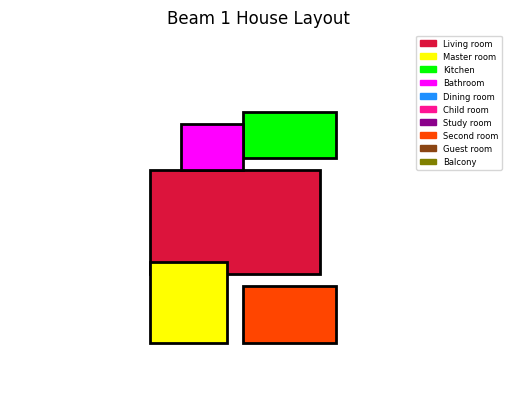

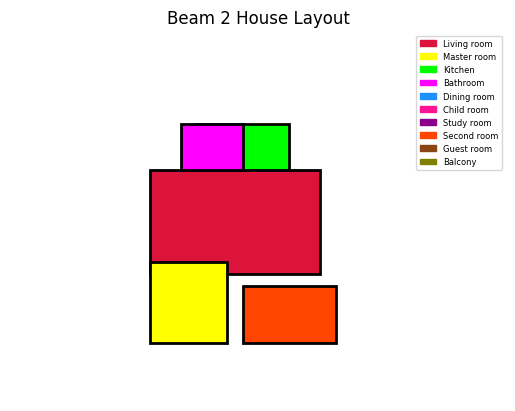

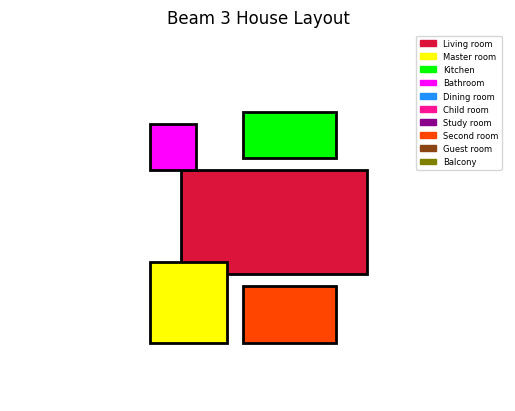

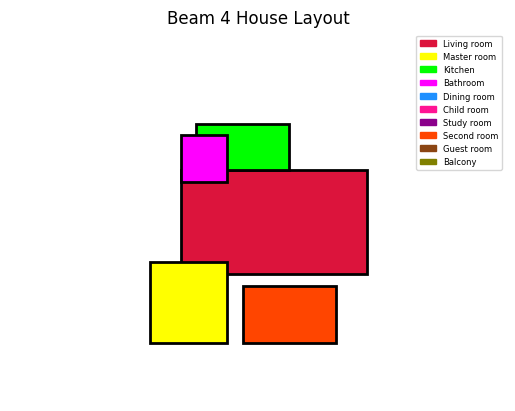

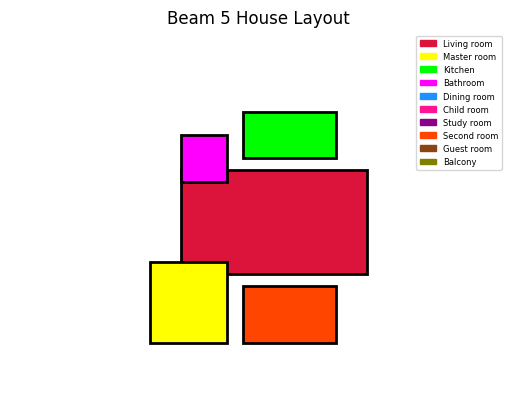

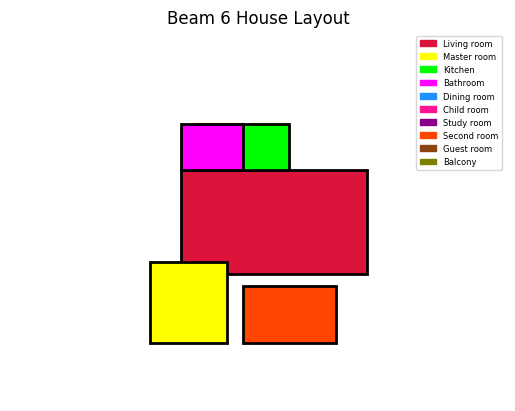

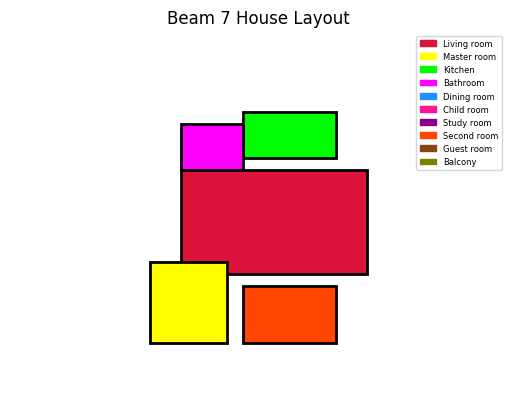

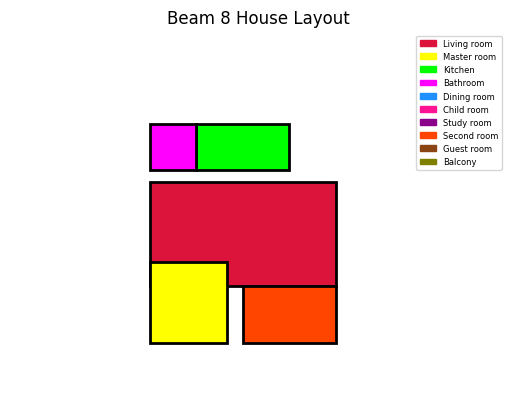

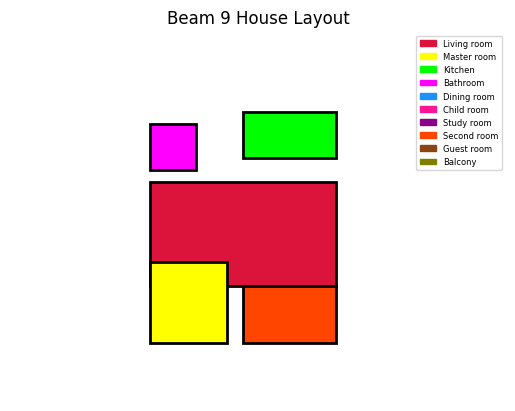

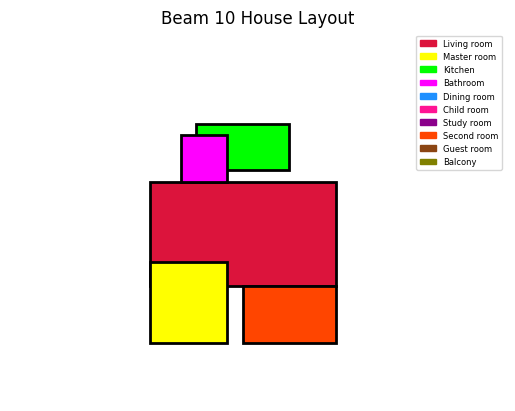

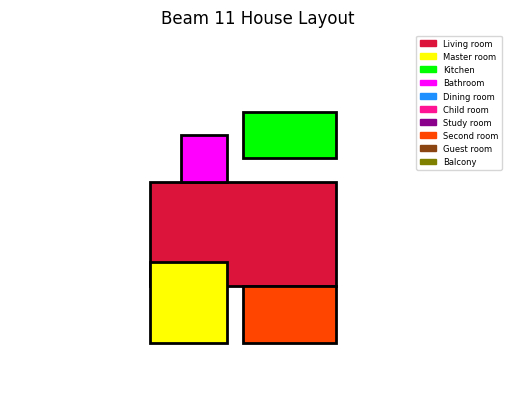

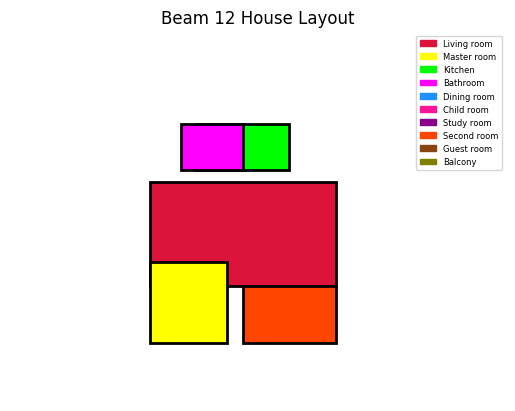

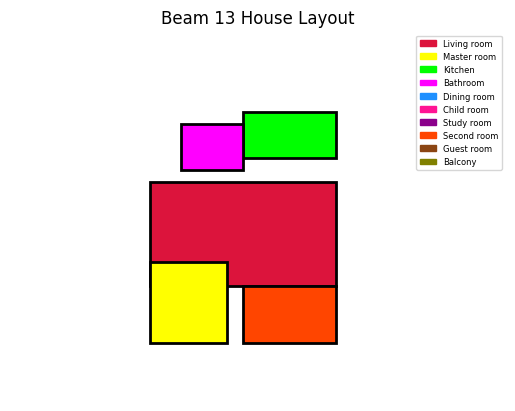

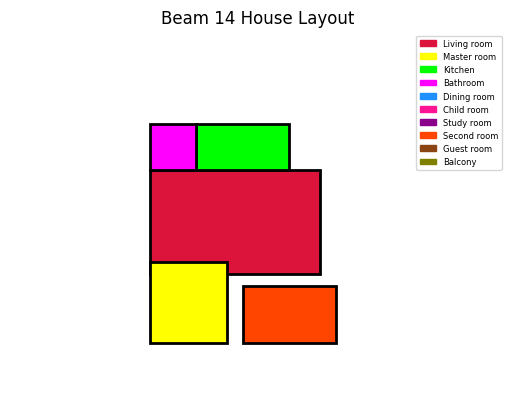

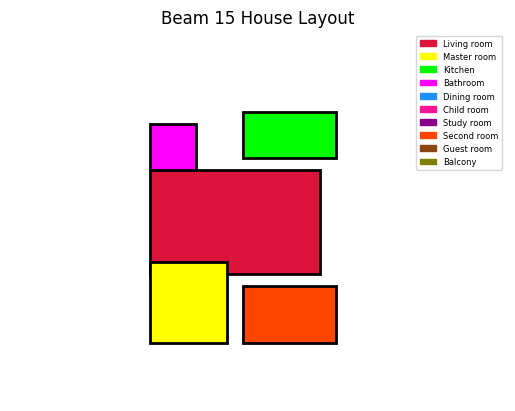

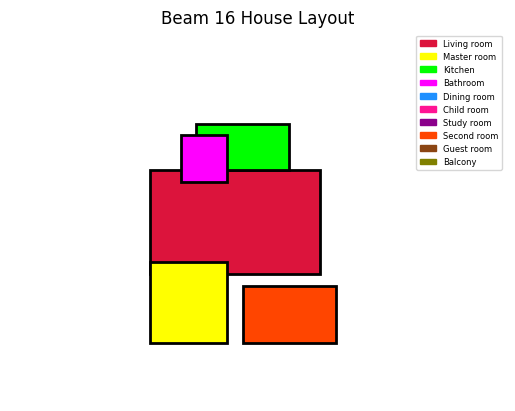

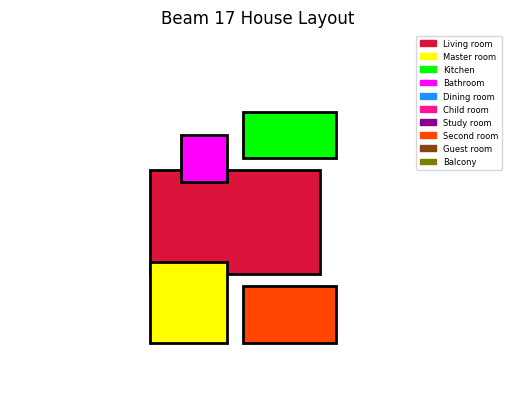

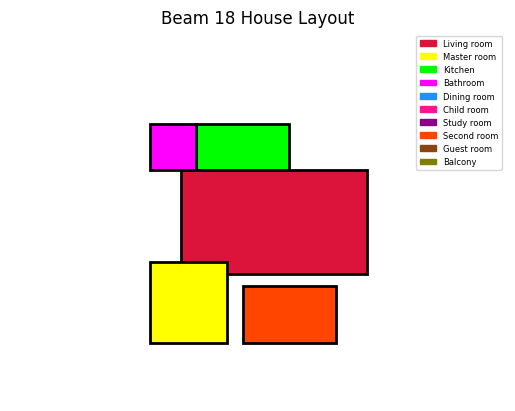

In [95]:
plt.style.use('default')
for i in range(len(res[0])):
  layout=res[0][i][0]
  fig, ax = plt.subplots()
  area=[]
  temp=[]
  for box in layout[0].T:
      c = np.argmax(box[0:publay_model.n_classes],axis=0)
      x = np.argmax(box[publay_model.n_classes:publay_model.n_classes+publay_model.n_col],axis=0)
      y = np.argmax(box[publay_model.n_classes+publay_model.n_col:publay_model.n_classes+publay_model.n_col+publay_model.n_row],axis=0)
      w = np.argmax(box[publay_model.n_classes+publay_model.n_col+publay_model.n_row:publay_model.n_classes+2*publay_model.n_col+publay_model.n_row],axis=0)
      h = np.argmax(box[publay_model.n_classes+2*publay_model.n_col+publay_model.n_row:publay_model.n_classes+2*publay_model.n_col+2*publay_model.n_row],axis=0)
      x,y,w,h=(x/32.0)*256,(y/32.0)*256,(w/32.0)*256,(h/32.0)*256
      area.append(w*h)
      temp.append((c,x,y,w,h))
      if c==publay_model.n_classes-1:
          break
  arr=np.argsort(area)[::-1]
  for j in arr:
    c,x,y,w,h=temp[j][0],temp[j][1],temp[j][2],temp[j][3],temp[j][4]
    if c>=2 and c<=11:
      r = plt.Rectangle((x,y),w,h, fc=get_color(c), ec='#000000',linewidth=2) #ffffff #000000
      ax.add_patch(r)


  ax.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1, 1),prop={'size': 6})
  ax.set_xlim(0, 256)
  ax.set_ylim(0, 256)
  ax.set_title("Beam "+str(i+1)+" House Layout")
  plt.axis('off')
  plt.show()

In [32]:
conversion_factor=18/256
total_house_layouts=len(res)
min_size=dict()
min_size[0]=11.5
min_size[1]=11
min_size[2]=5
min_size[3]=1.8
min_size[4]=7.5
min_size[5]=9
min_size[6]=9
min_size[7]=7.5
min_size[8]=12
min_size[9]=1.5
min_win=dict()
min_win[0]=3
min_win[1]=3
min_win[2]=1.8
min_win[3]=1.2
min_win[4]=2.5
min_win[5]=3
min_win[6]=3
min_win[7]=2.5
min_win[8]=3
min_win[9]=0.7
total_rooms=[0,0,0,0,0,0,0,0,0,0]
total_invalid_areas=[0,0,0,0,0,0,0,0,0,0]
total_invalid_width=[0,0,0,0,0,0,0,0,0,0]

In [33]:
for i in range(len(res)):
  layout=res[i][0]
  for box in layout[0].T:
      c = np.argmax(box[0:publay_model.n_classes],axis=0)
      x = np.argmax(box[publay_model.n_classes:publay_model.n_classes+publay_model.n_col],axis=0)
      y = np.argmax(box[publay_model.n_classes+publay_model.n_col:publay_model.n_classes+publay_model.n_col+publay_model.n_row],axis=0)
      w = np.argmax(box[publay_model.n_classes+publay_model.n_col+publay_model.n_row:publay_model.n_classes+2*publay_model.n_col+publay_model.n_row],axis=0)
      h = np.argmax(box[publay_model.n_classes+2*publay_model.n_col+publay_model.n_row:publay_model.n_classes+2*publay_model.n_col+2*publay_model.n_row],axis=0)
      x,y,w,h=(x/32.0)*256,(y/32.0)*256,(w/32.0)*256,(h/32.0)*256
      #print(c,w[0]*conversion_factor,h[0]*conversion_factor)
      c=int(c)
      if c>=2 and c<=11:
          total_rooms[c-2]+=1
          area=(w[0]*h[0])*conversion_factor**2
          min_width=min(w[0],h[0])*conversion_factor
          if(area<min_size[c-2]):
            total_invalid_areas[c-2]+=1
          if(min_width<min_win[c-2]):
            #print(c-2,min_width,min_win[c-2])
            total_invalid_width[c-2]+=1
      if c==publay_model.n_classes-1:
          break

C:\Users\kishore prashanth\AppData\Local\Temp\ipykernel_5192\2067903912.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c=int(c)


In [34]:
total_rooms

[1, 1, 1, 1, 0, 0, 0, 2, 0, 1]

In [35]:
total_invalid_areas

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [36]:
total_invalid_width

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]

In [37]:
np.array(total_invalid_areas)/np.array(total_rooms)

C:\Users\kishore prashanth\AppData\Local\Temp\ipykernel_5192\2131832225.py:1: RuntimeWarning: invalid value encountered in divide
  np.array(total_invalid_areas)/np.array(total_rooms)


array([ 0.,  0.,  0.,  0., nan, nan, nan,  0., nan,  0.])

In [38]:
np.array(total_invalid_width)/np.array(total_rooms)

C:\Users\kishore prashanth\AppData\Local\Temp\ipykernel_5192\3384148782.py:1: RuntimeWarning: invalid value encountered in divide
  np.array(total_invalid_width)/np.array(total_rooms)


array([0. , 0. , 0. , 1. , nan, nan, nan, 0.5, nan, 0. ])

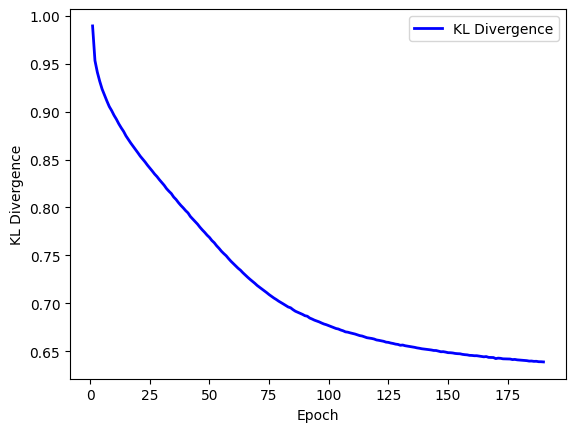

In [39]:
with open('./modelT20.json') as file:
    data=json.load(file)
history_loss=data['loss']

plt.plot(range(1, len(history_loss) + 1), history_loss, '-', color='blue', linewidth=2, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.legend()
plt.show()